In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [2]:
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('Boston.csv')
house_df.take(1)

[Row(_c0=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [3]:
house_df.cache()
house_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [4]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
_c0,506,253.5,146.2138844296259,1,506
crim,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
zn,506,11.363636363636363,23.32245299451514,0.0,100.0
indus,506,11.136778656126504,6.860352940897589,0.46,27.74
chas,506,0.0691699604743083,0.2539940413404101,0,1
nox,506,0.5546950592885372,0.11587767566755584,0.385,0.871
rm,506,6.284634387351787,0.7026171434153232,3.561,8.78
age,506,68.57490118577078,28.148861406903595,2.9,100.0
dis,506,3.795042687747034,2.10571012662761,1.1296,12.1265


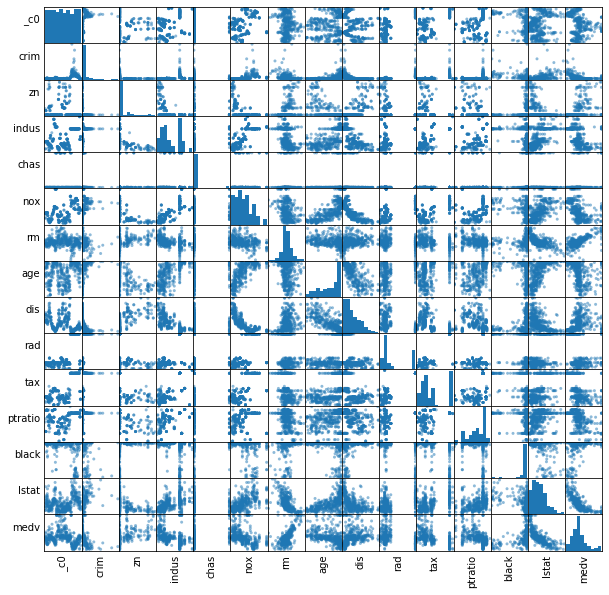

In [7]:
import pandas as pd
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [5]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MedV for ", i, house_df.stat.corr('medv',i))

Correlation to MedV for  _c0 -0.22660364293533927
Correlation to MedV for  crim -0.38830460858681154
Correlation to MedV for  zn 0.3604453424505433
Correlation to MedV for  indus -0.4837251600283728
Correlation to MedV for  chas 0.1752601771902987
Correlation to MedV for  nox -0.4273207723732821
Correlation to MedV for  rm 0.6953599470715401
Correlation to MedV for  age -0.3769545650045961
Correlation to MedV for  dis 0.249928734085904
Correlation to MedV for  rad -0.38162623063977735
Correlation to MedV for  tax -0.46853593356776674
Correlation to MedV for  ptratio -0.5077866855375622
Correlation to MedV for  black 0.3334608196570661
Correlation to MedV for  lstat -0.7376627261740145
Correlation to MedV for  medv 1.0


In [6]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], \
                            outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



In [7]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [8]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.050683362106201155,0.0,0.0,1.2592485612158342,-8.074166972865669,4.946369098815099,-0.006131069416910137,-0.5452557677237558,0.0,-0.0019757610364774607,-0.9376643482944547,0.00555837734258662,-0.4418848970461292]
Intercept: 20.174676681797646


In [9]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.627991
r2: 0.754717


In [10]:
train_df.describe().show()

+-------+-----------------+
|summary|             medv|
+-------+-----------------+
|  count|              354|
|   mean|22.34378531073447|
| stddev|9.357781650345043|
|    min|              5.0|
|    max|             50.0|
+-------+-----------------+



In [11]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.797432924564397|24.0|[0.00632,18.0,2.3...|
| 31.10273543053046|29.1|[0.01439,60.0,2.9...|
|27.781699868189875|24.5|[0.01501,80.0,2.0...|
|35.580645644953435|44.0|[0.01538,90.0,3.7...|
|27.147928149435984|30.1|[0.01709,90.0,2.0...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.590324


In [12]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.63056


In [13]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5, 0.4288800263670779, 0.21359000758120272, 0.19070015427217737, 0.1611566551385771, 0.15999073745903694, 0.15949859260851515, 0.15875053850420717, 0.15858769415797763, 0.15845980889961894, 0.1583098300701819]
+--------------------+
|           residuals|
+--------------------+
|  0.4916090030149789|
|  -6.390558610598568|
|-0.25542909835920824|
|   4.655241041906727|
|   2.240273548362122|
|   10.68398668876641|
|0.043618848817800426|
|   8.316717505205546|
|  1.5109058327606846|
| -2.9099022594086463|
|   5.679323377648135|
|   9.761113842530662|
|    -1.3238672492507|
| -0.8318441473810942|
|  2.6226354017520634|
|  -4.353795329343569|
|  1.9068324797122713|
| -1.8325633701436885|
| 0.14285645905366096|
|   4.290175545641361|
+--------------------+
only showing top 20 rows



In [14]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.797432924564397|24.0|[0.00632,18.0,2.3...|
| 31.10273543053046|29.1|[0.01439,60.0,2.9...|
|27.781699868189875|24.5|[0.01501,80.0,2.0...|
|35.580645644953435|44.0|[0.01538,90.0,3.7...|
|27.147928149435984|30.1|[0.01709,90.0,2.0...|
|21.375458976840612|20.1|[0.01965,80.0,1.7...|
|  37.3018298430506|42.3|[0.02177,82.5,2.0...|
| 27.15976398457176|16.5|[0.02498,0.0,1.89...|
|27.714587866417496|23.9|[0.02543,55.0,3.7...|
|26.530510426825415|28.7|[0.02985,0.0,2.18...|
| 19.89157051232901|18.5|[0.03041,0.0,5.19...|
|  29.4544661939603|31.2|[0.03049,55.0,3.7...|
|20.851889419774974|17.5|[0.03113,0.0,4.39...|
| 30.42492463709746|33.4|[0.03237,0.0,2.18...|
| 20.40108572085721|19.5|[0.03427,0.0,5.19...|
| 24.81146502708126|19.4|[0.03466,35.0,6.0...|
|30.077916807053867|28.5|[0.03502,80.0,4.9...|
| 28.28666569201752|22.0|[0.03537,34.0,6.0...|
| 24.48841373

In [15]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.55917


In [16]:
dt_model.featureImportances

SparseVector(13, {0: 0.0335, 2: 0.0031, 4: 0.0383, 5: 0.6424, 6: 0.0091, 7: 0.0385, 10: 0.0405, 11: 0.0009, 12: 0.1939})

In [17]:
house_df.take(1)

[Row(_c0=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [18]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|25.545583458668915|24.0|[0.00632,18.0,2.3...|
|29.710515531370135|29.1|[0.01439,60.0,2.9...|
|24.969635703361014|24.5|[0.01501,80.0,2.0...|
| 47.74608016276259|44.0|[0.01538,90.0,3.7...|
| 27.97847404719945|30.1|[0.01709,90.0,2.0...|
+------------------+----+--------------------+
only showing top 5 rows



In [19]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.31047
